In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore Data

In [3]:
# Load the dataset
df = pd.read_csv('all_cards_master_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

Dataset shape: (48847, 62)

First few rows:
      game                 set_name  \
0  Pokemon  ME02: Phantasmal Flames   
1  Pokemon  ME02: Phantasmal Flames   
2  Pokemon  ME02: Phantasmal Flames   
3  Pokemon  ME02: Phantasmal Flames   
4  Pokemon  ME02: Phantasmal Flames   

                                             card_id  \
0  pokemon-me02-phantasmal-flames-phantasmal-flam...   
1  pokemon-me02-phantasmal-flames-phantasmal-flam...   
2  pokemon-me02-phantasmal-flames-phantasmal-flam...   
3  pokemon-me02-phantasmal-flames-phantasmal-flam...   
4  pokemon-me02-phantasmal-flames-mega-charizard-...   

                                  card_name   number  \
0        Phantasmal Flames Booster Box Case      NaN   
1     Phantasmal Flames Booster Bundle Case      NaN   
2    Phantasmal Flames Sleeved Booster Case      NaN   
3  Phantasmal Flames Elite Trainer Box Case      NaN   
4             Mega Charizard X ex - 125/094  125/094   

                      rarity                   

In [4]:
# Examine target variables
target_vars = ['priceChange24hr', '7d_priceChange', 'price', '7d_stddevPopPrice']

print("Target Variables Statistics:")
print(df[target_vars].describe())
print(f"\nMissing values in targets:")
print(df[target_vars].isnull().sum())

Target Variables Statistics:
       priceChange24hr  7d_priceChange         price  7d_stddevPopPrice
count     43760.000000    43940.000000  48847.000000       43940.000000
mean          0.101053        0.191703     23.422604           0.330668
std           5.766481       28.456186    273.874568           8.633851
min         -66.670000      -90.570000      0.010000           0.000000
25%           0.000000       -1.630000      0.530000           0.000000
50%           0.000000        0.000000      2.740000           0.000000
75%           0.000000        0.000000     10.190000           0.070000
max         884.000000     3400.000000  32999.990000        1662.960000

Missing values in targets:
priceChange24hr      5087
7d_priceChange       4907
price                   0
7d_stddevPopPrice    4907
dtype: int64


## 2. Data Preprocessing

In [5]:
# Improved feature engineering and preprocessing function
def prepare_features(df, target_column):
    """
    Prepare features for modeling with improved data cleaning and feature engineering
    """
    # Create a copy to avoid modifying original
    df_model = df.copy()
    
    # Drop rows where target is missing
    df_model = df_model[df_model[target_column].notna()].copy()
    
    print(f"\n{'='*60}")
    print(f"Preparing features for: {target_column}")
    print(f"{'='*60}")
    
    # Select numeric features (excluding targets and identifiers)
    numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude target variables and ID columns from features
    exclude_cols = ['priceChange24hr', '7d_priceChange', 'price', '7d_stddevPopPrice',
                    'tcgplayerId', 'tcgplayerSkuId', 'lastUpdated']
    
    numeric_features = [col for col in numeric_cols if col not in exclude_cols]
    
    # Remove columns that are all NaN or all zeros
    cols_to_remove = []
    for col in numeric_features:
        if df_model[col].isna().all():
            cols_to_remove.append(col)
            print(f"  Removing {col}: All NaN values")
        elif (df_model[col].fillna(0) == 0).all():
            cols_to_remove.append(col)
            print(f"  Removing {col}: All zero values")
        elif df_model[col].nunique() == 1:
            cols_to_remove.append(col)
            print(f"  Removing {col}: No variance (constant)")
    
    numeric_features = [col for col in numeric_features if col not in cols_to_remove]
    
    # Remove highly sparse columns (>95% missing)
    sparse_threshold = 0.95
    for col in numeric_features.copy():
        missing_ratio = df_model[col].isna().sum() / len(df_model)
        if missing_ratio > sparse_threshold:
            numeric_features.remove(col)
            print(f"  Removing {col}: {missing_ratio*100:.1f}% missing values")
    
    # Handle missing values in numeric features (use median)
    for col in numeric_features:
        if df_model[col].isna().any():
            df_model[col].fillna(df_model[col].median(), inplace=True)
    
    # Categorical features to encode
    categorical_features = ['game', 'rarity', 'condition', 'printing', 'language']
    
    # Handle missing values in categorical features
    for col in categorical_features:
        if col in df_model.columns:
            df_model[col].fillna('Unknown', inplace=True)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_features:
        if col in df_model.columns:
            le = LabelEncoder()
            df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
            label_encoders[col] = le
            numeric_features.append(col + '_encoded')
    
    # Handle outliers using IQR method for the target variable
    Q1 = df_model[target_column].quantile(0.01)
    Q3 = df_model[target_column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    original_size = len(df_model)
    df_model = df_model[(df_model[target_column] >= lower_bound) & 
                        (df_model[target_column] <= upper_bound)]
    removed_outliers = original_size - len(df_model)
    
    if removed_outliers > 0:
        print(f"  Removed {removed_outliers} outliers ({removed_outliers/original_size*100:.2f}%)")
    
    # Prepare feature matrix and target
    X = df_model[numeric_features]
    y = df_model[target_column]
    
    print(f"  Final feature count: {len(numeric_features)}")
    print(f"  Final sample count: {len(X)}")
    print(f"  Target range: [{y.min():.2f}, {y.max():.2f}]")
    
    return X, y, numeric_features, label_encoders


## 3. Model Training and Evaluation Framework

In [6]:
# Improved model training and evaluation function - Auto-selects best model
def train_and_evaluate_model(X, y, target_name, model_type='auto'):
    """
    Train and evaluate multiple regression models, automatically selecting the best one
    If model_type='auto', trains all models and selects the best based on test R²
    """
    # Split data (same split for all models)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Use RobustScaler (better for outliers)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define all available models
    model_configs = {
        'xgboost': {
            'model': xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                min_child_weight=3,
                gamma=0.1,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1
            ),
            'use_scaled': False
        },
        'random_forest': {
            'model': RandomForestRegressor(
                n_estimators=200, 
                max_depth=20, 
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                random_state=42, 
                n_jobs=-1
            ),
            'use_scaled': False
        },
        'gradient_boosting': {
            'model': GradientBoostingRegressor(
                n_estimators=200, 
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42
            ),
            'use_scaled': False
        },
        'ridge': {
            'model': Ridge(alpha=1.0, random_state=42),
            'use_scaled': True
        }
    }
    
    # If auto mode, train all models and select best
    if model_type == 'auto':
        print(f"\n{'='*60}")
        print(f"AUTO-SELECTING BEST MODEL FOR: {target_name}")
        print(f"{'='*60}")
        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
        print(f"\nTraining and comparing all models...\n")
        
        results = {}
        
        for name, config in model_configs.items():
            model = config['model']
            
            # Train model
            if config['use_scaled']:
                model.fit(X_train_scaled, y_train)
                y_train_pred = model.predict(X_train_scaled)
                y_test_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)
            
            # Calculate metrics
            test_r2 = r2_score(y_test, y_test_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_mae = mean_absolute_error(y_test, y_test_pred)
            
            results[name] = {
                'model': model,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'train_pred': y_train_pred,
                'test_pred': y_test_pred,
                'use_scaled': config['use_scaled']
            }
            
            print(f"{name.upper():20s} → Test R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")
        
        # Select best model based on test R²
        best_model_name = max(results, key=lambda x: results[x]['test_r2'])
        best_result = results[best_model_name]
        
        print(f"\n{'='*60}")
        print(f"BEST MODEL: {best_model_name.upper()}")
        print(f"{'='*60}")
        
        model = best_result['model']
        y_train_pred = best_result['train_pred']
        y_test_pred = best_result['test_pred']
        model_type = best_model_name
        
    else:
        # Train single specified model
        if model_type not in model_configs:
            raise ValueError(f"Invalid model type. Choose from: {list(model_configs.keys())} or 'auto'")
        
        config = model_configs[model_type]
        model = config['model']
        
        print(f"\n{'='*60}")
        print(f"Training {model_type.upper()} for: {target_name}")
        print(f"{'='*60}")
        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
        
        # Train model
        if config['use_scaled']:
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
    
    # Calculate final metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"\nTraining Metrics:")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\nTest Metrics:")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")
    
    # Feature importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        print(f"\nTop 15 Most Important Features:")
        print(feature_importance.to_string(index=False))
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Actual vs Predicted
    axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title(f'{target_name}: Actual vs Predicted\nTest R² = {test_r2:.4f}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_test - y_test_pred
    axes[1].scatter(y_test_pred, residuals, alpha=0.5, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'{target_name}: Residual Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler, {
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_mae': train_mae, 'test_mae': test_mae,
        'train_r2': train_r2, 'test_r2': test_r2,
        'model_type': model_type
    }


## 4. Model 1: Predict priceChange24hr (24-hour price change)

In [7]:
# Prepare data for priceChange24hr
X_24hr, y_24hr, features_24hr, encoders_24hr = prepare_features(df, 'priceChange24hr')

print(f"Features prepared for priceChange24hr:")
print(f"  Number of samples: {len(X_24hr)}")
print(f"  Number of features: {len(features_24hr)}")
print(f"  Target range: [{y_24hr.min():.2f}, {y_24hr.max():.2f}]")


Preparing features for: priceChange24hr
  Removing details: All NaN values
  Removing 7d_avgPrice: All NaN values
  Removing 7d_priceRelativeToRange: All NaN values
  Removing 1y_priceChange: All NaN values
  Removing 1y_avgPrice: All NaN values
  Removing 1y_stddevPopPrice: All NaN values
  Removing 1y_covPrice: All NaN values
  Removing 1y_iqrPrice: All NaN values
  Removing 1y_trendSlope: All NaN values
  Removing 1y_priceChangesCount: All NaN values
  Removing 1y_priceRelativeToRange: All NaN values
  Removing minPriceAllTime: All NaN values
  Removing minPriceAllTimeDate: All NaN values
  Removing maxPriceAllTime: All NaN values
  Removing maxPriceAllTimeDate: All NaN values
  Removing details: All NaN values
  Removing 7d_avgPrice: All NaN values
  Removing 7d_priceRelativeToRange: All NaN values
  Removing 1y_priceChange: All NaN values
  Removing 1y_avgPrice: All NaN values
  Removing 1y_stddevPopPrice: All NaN values
  Removing 1y_covPrice: All NaN values
  Removing 1y_iqrPri


AUTO-SELECTING BEST MODEL FOR: priceChange24hr
Training samples: 35000, Test samples: 8751

Training and comparing all models...

XGBOOST              → Test R²: 0.3595, RMSE: 2.5876, MAE: 0.9953
XGBOOST              → Test R²: 0.3595, RMSE: 2.5876, MAE: 0.9953
RANDOM_FOREST        → Test R²: 0.2914, RMSE: 2.7217, MAE: 0.9839
RANDOM_FOREST        → Test R²: 0.2914, RMSE: 2.7217, MAE: 0.9839
GRADIENT_BOOSTING    → Test R²: 0.3362, RMSE: 2.6343, MAE: 0.9994
RIDGE                → Test R²: -0.4032, RMSE: 3.8299, MAE: 1.3314

BEST MODEL: XGBOOST

Training Metrics:
  RMSE: 1.3873
  MAE:  0.6617
  R²:   0.8364

Test Metrics:
  RMSE: 2.5876
  MAE:  0.9953
  R²:   0.3595

Top 15 Most Important Features:
                 feature  importance
30d_priceRelativeToRange    0.062863
          30d_trendSlope    0.054075
             7d_covPrice    0.047635
             7d_iqrPrice    0.047210
            30d_covPrice    0.043728
90d_priceRelativeToRange    0.040214
         30d_priceChange    0.03391

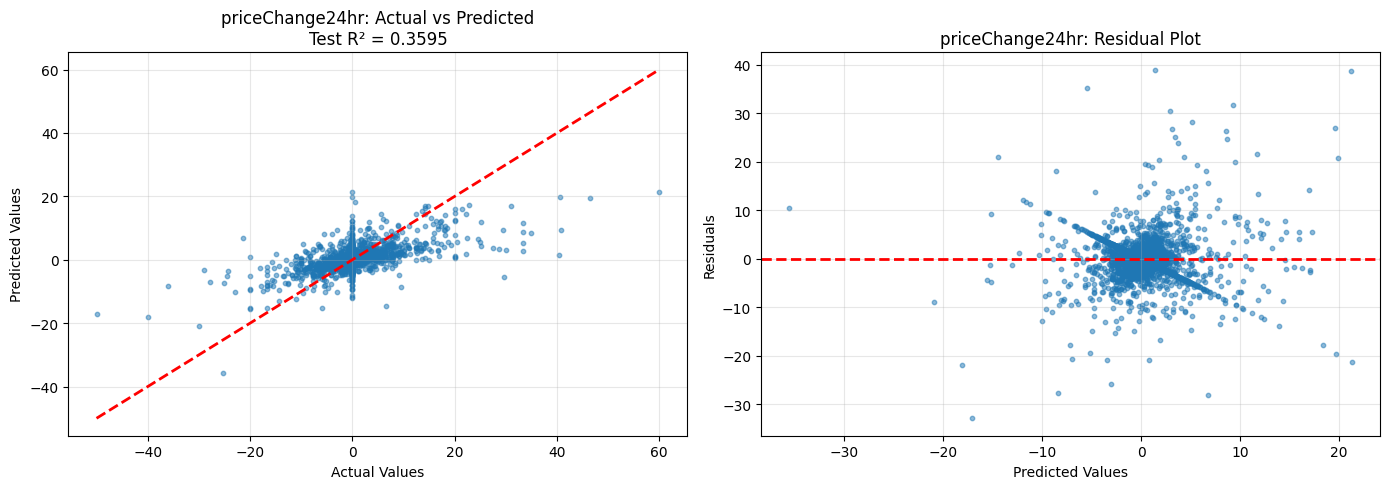

In [8]:
# Auto-select best model for priceChange24hr
model_24hr_best, scaler_24hr_best, metrics_24hr_best = train_and_evaluate_model(
    X_24hr, y_24hr, 'priceChange24hr', model_type='auto'
)

## 5. Model 2: Predict 7d_priceChange (7-day price change)

In [9]:
# Prepare data for 7d_priceChange
X_7d, y_7d, features_7d, encoders_7d = prepare_features(df, '7d_priceChange')

print(f"Features prepared for 7d_priceChange:")
print(f"  Number of samples: {len(X_7d)}")
print(f"  Number of features: {len(features_7d)}")
print(f"  Target range: [{y_7d.min():.2f}, {y_7d.max():.2f}]")


Preparing features for: 7d_priceChange
  Removing details: All NaN values
  Removing 7d_avgPrice: All NaN values
  Removing 7d_priceRelativeToRange: All NaN values
  Removing 1y_priceChange: All NaN values
  Removing 1y_avgPrice: All NaN values
  Removing 1y_stddevPopPrice: All NaN values
  Removing 1y_covPrice: All NaN values
  Removing 1y_iqrPrice: All NaN values
  Removing 1y_trendSlope: All NaN values
  Removing 1y_priceChangesCount: All NaN values
  Removing 1y_priceRelativeToRange: All NaN values
  Removing minPriceAllTime: All NaN values
  Removing minPriceAllTimeDate: All NaN values
  Removing maxPriceAllTime: All NaN values
  Removing maxPriceAllTimeDate: All NaN values
  Removed 14 outliers (0.03%)
  Final feature count: 33
  Final sample count: 43926
  Target range: [-90.57, 260.18]
Features prepared for 7d_priceChange:
  Number of samples: 43926
  Number of features: 33
  Target range: [-90.57, 260.18]



AUTO-SELECTING BEST MODEL FOR: 7d_priceChange
Training samples: 35140, Test samples: 8786

Training and comparing all models...

XGBOOST              → Test R²: 0.9300, RMSE: 3.2674, MAE: 1.1016
XGBOOST              → Test R²: 0.9300, RMSE: 3.2674, MAE: 1.1016
RANDOM_FOREST        → Test R²: 0.8789, RMSE: 4.2958, MAE: 1.3083
RANDOM_FOREST        → Test R²: 0.8789, RMSE: 4.2958, MAE: 1.3083
GRADIENT_BOOSTING    → Test R²: 0.9267, RMSE: 3.3423, MAE: 1.0837
RIDGE                → Test R²: -5.0027, RMSE: 30.2500, MAE: 5.7286

BEST MODEL: XGBOOST

Training Metrics:
  RMSE: 1.3767
  MAE:  0.6641
  R²:   0.9864

Test Metrics:
  RMSE: 3.2674
  MAE:  1.1016
  R²:   0.9300

Top 15 Most Important Features:
                 feature  importance
             7d_covPrice    0.303154
           7d_trendSlope    0.147687
30d_priceRelativeToRange    0.127293
            30d_covPrice    0.063964
             7d_iqrPrice    0.034801
         30d_priceChange    0.034150
      30d_stddevPopPrice    0.03290

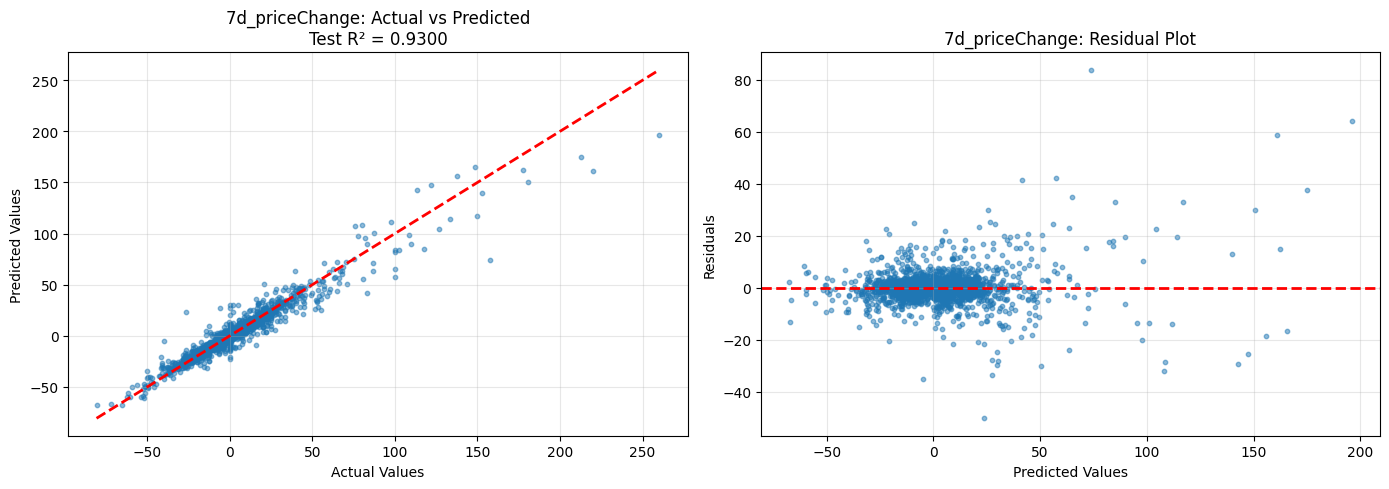

In [10]:
# Auto-select best model for 7d_priceChange
model_7d_best, scaler_7d_best, metrics_7d_best = train_and_evaluate_model(
    X_7d, y_7d, '7d_priceChange', model_type='auto'
)

## 6. Model 3: Predict price (Current card price)

In [11]:
# Prepare data for price
X_price, y_price, features_price, encoders_price = prepare_features(df, 'price')

print(f"Features prepared for price:")
print(f"  Number of samples: {len(X_price)}")
print(f"  Number of features: {len(features_price)}")
print(f"  Target range: [{y_price.min():.2f}, {y_price.max():.2f}]")


Preparing features for: price
  Removing details: All NaN values
  Removing 7d_avgPrice: All NaN values
  Removing 7d_priceRelativeToRange: All NaN values
  Removing 1y_priceChange: All NaN values
  Removing 1y_avgPrice: All NaN values
  Removing 1y_stddevPopPrice: All NaN values
  Removing 1y_covPrice: All NaN values
  Removing 1y_iqrPrice: All NaN values
  Removing 1y_trendSlope: All NaN values
  Removing 1y_priceChangesCount: All NaN values
  Removing 1y_priceRelativeToRange: All NaN values
  Removing minPriceAllTime: All NaN values
  Removing minPriceAllTimeDate: All NaN values
  Removing maxPriceAllTime: All NaN values
  Removing maxPriceAllTimeDate: All NaN values
  Removed 104 outliers (0.21%)
  Final feature count: 33
  Final sample count: 48743
  Target range: [0.01, 1236.93]
Features prepared for price:
  Number of samples: 48743
  Number of features: 33
  Target range: [0.01, 1236.93]



AUTO-SELECTING BEST MODEL FOR: price
Training samples: 38994, Test samples: 9749

Training and comparing all models...

XGBOOST              → Test R²: 0.9629, RMSE: 11.8068, MAE: 1.0740
XGBOOST              → Test R²: 0.9629, RMSE: 11.8068, MAE: 1.0740
RANDOM_FOREST        → Test R²: 0.9910, RMSE: 5.8020, MAE: 0.3940
RANDOM_FOREST        → Test R²: 0.9910, RMSE: 5.8020, MAE: 0.3940
GRADIENT_BOOSTING    → Test R²: 0.9957, RMSE: 4.0074, MAE: 0.4152
RIDGE                → Test R²: 0.9738, RMSE: 9.9119, MAE: 2.4426

BEST MODEL: GRADIENT_BOOSTING

Training Metrics:
  RMSE: 0.2866
  MAE:  0.1576
  R²:   1.0000

Test Metrics:
  RMSE: 4.0074
  MAE:  0.4152
  R²:   0.9957

Top 15 Most Important Features:
                 feature  importance
            90d_avgPrice    0.545161
             1y_minPrice    0.253315
            90d_minPrice    0.139587
             7d_maxPrice    0.021523
             7d_minPrice    0.014370
            30d_minPrice    0.012911
             1y_maxPrice    0.0062

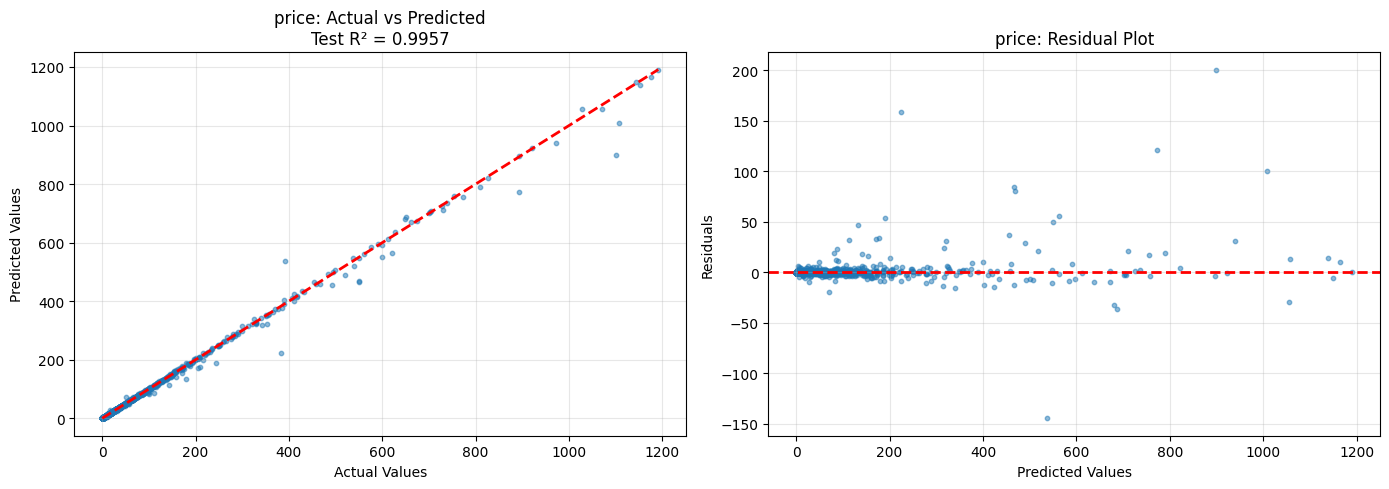

In [12]:
# Auto-select best model for price
model_price_best, scaler_price_best, metrics_price_best = train_and_evaluate_model(
    X_price, y_price, 'price', model_type='auto'
)

## 7. Model 4: Predict 7d_stddevPopPrice (7-day price volatility)

In [13]:
# Prepare data for 7d_stddevPopPrice
X_stddev, y_stddev, features_stddev, encoders_stddev = prepare_features(df, '7d_stddevPopPrice')

print(f"Features prepared for 7d_stddevPopPrice:")
print(f"  Number of samples: {len(X_stddev)}")
print(f"  Number of features: {len(features_stddev)}")
print(f"  Target range: [{y_stddev.min():.2f}, {y_stddev.max():.2f}]")


Preparing features for: 7d_stddevPopPrice
  Removing details: All NaN values
  Removing 7d_avgPrice: All NaN values
  Removing 7d_priceRelativeToRange: All NaN values
  Removing 1y_priceChange: All NaN values
  Removing 1y_avgPrice: All NaN values
  Removing 1y_stddevPopPrice: All NaN values
  Removing 1y_covPrice: All NaN values
  Removing 1y_iqrPrice: All NaN values
  Removing 1y_trendSlope: All NaN values
  Removing 1y_priceChangesCount: All NaN values
  Removing 1y_priceRelativeToRange: All NaN values
  Removing minPriceAllTime: All NaN values
  Removing minPriceAllTimeDate: All NaN values
  Removing maxPriceAllTime: All NaN values
  Removing maxPriceAllTimeDate: All NaN values
  Removed 105 outliers (0.24%)
  Final feature count: 33
  Final sample count: 43835
  Target range: [0.00, 15.98]
Features prepared for 7d_stddevPopPrice:
  Number of samples: 43835
  Number of features: 33
  Target range: [0.00, 15.98]



AUTO-SELECTING BEST MODEL FOR: 7d_stddevPopPrice
Training samples: 35068, Test samples: 8767

Training and comparing all models...

XGBOOST              → Test R²: 0.9573, RMSE: 0.1573, MAE: 0.0248
XGBOOST              → Test R²: 0.9573, RMSE: 0.1573, MAE: 0.0248
RANDOM_FOREST        → Test R²: 0.9458, RMSE: 0.1773, MAE: 0.0252
RANDOM_FOREST        → Test R²: 0.9458, RMSE: 0.1773, MAE: 0.0252
GRADIENT_BOOSTING    → Test R²: 0.9634, RMSE: 0.1458, MAE: 0.0180
RIDGE                → Test R²: 0.9897, RMSE: 0.0772, MAE: 0.0210

BEST MODEL: RIDGE

Training Metrics:
  RMSE: 0.0867
  MAE:  0.0212
  R²:   0.9877

Test Metrics:
  RMSE: 0.0772
  MAE:  0.0210
  R²:   0.9897
GRADIENT_BOOSTING    → Test R²: 0.9634, RMSE: 0.1458, MAE: 0.0180
RIDGE                → Test R²: 0.9897, RMSE: 0.0772, MAE: 0.0210

BEST MODEL: RIDGE

Training Metrics:
  RMSE: 0.0867
  MAE:  0.0212
  R²:   0.9877

Test Metrics:
  RMSE: 0.0772
  MAE:  0.0210
  R²:   0.9897


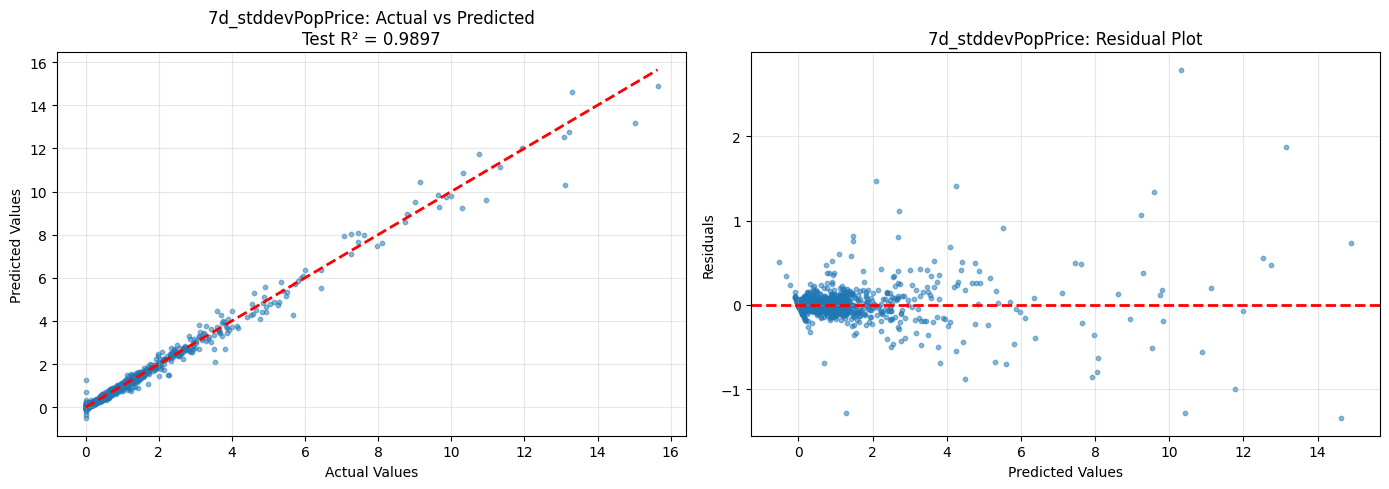

In [14]:
# Auto-select best model for 7d_stddevPopPrice
model_stddev_best, scaler_stddev_best, metrics_stddev_best = train_and_evaluate_model(
    X_stddev, y_stddev, '7d_stddevPopPrice', model_type='auto'
)

## 8. Summary of All Models


SUMMARY: AUTO-SELECTED BEST MODELS PERFORMANCE
  Target Variable        Best Model  Test RMSE  Test MAE  Test R²  Training Samples
  priceChange24hr           XGBOOST   2.587627  0.995332 0.359474             43751
   7d_priceChange           XGBOOST   3.267363  1.101633 0.929969             43926
            price GRADIENT_BOOSTING   4.007378  0.415208 0.995721             48743
7d_stddevPopPrice             RIDGE   0.077165  0.020983 0.989737             43835


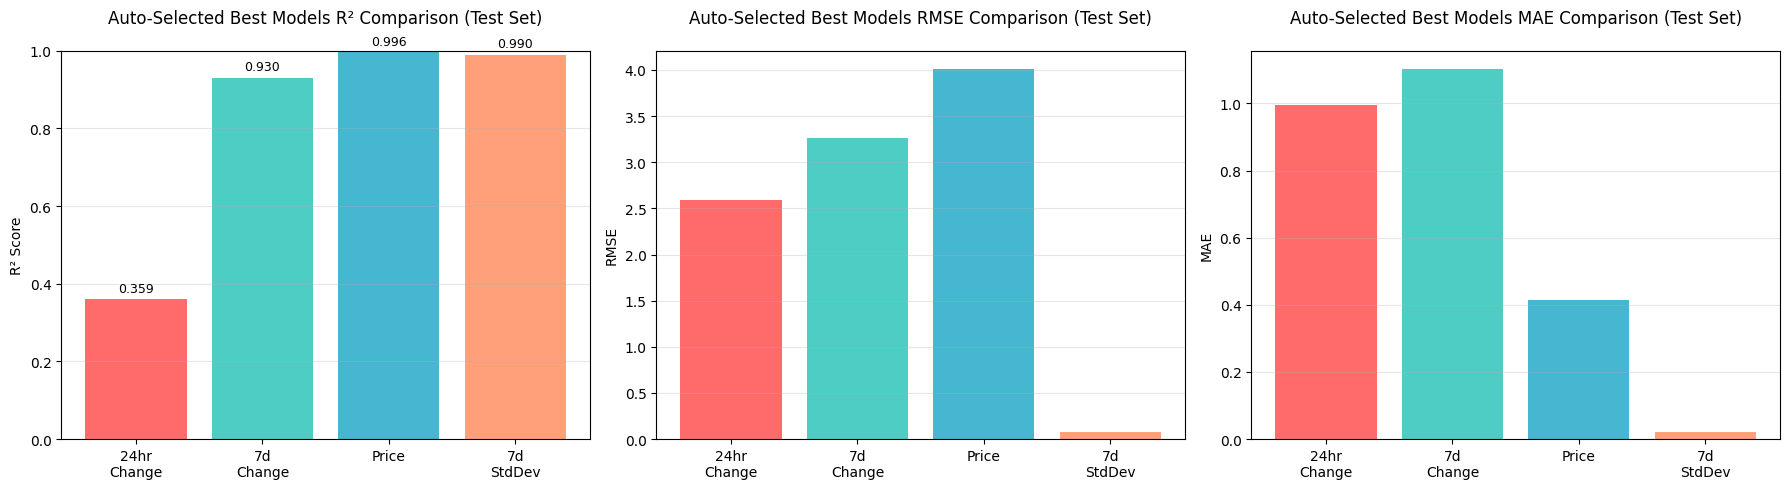

In [15]:
# Create summary comparison table with model types
summary_df = pd.DataFrame({
    'Target Variable': ['priceChange24hr', '7d_priceChange', 'price', '7d_stddevPopPrice'],
    'Best Model': [
        metrics_24hr_best['model_type'].upper(),
        metrics_7d_best['model_type'].upper(),
        metrics_price_best['model_type'].upper(),
        metrics_stddev_best['model_type'].upper()
    ],
    'Test RMSE': [
        metrics_24hr_best['test_rmse'],
        metrics_7d_best['test_rmse'],
        metrics_price_best['test_rmse'],
        metrics_stddev_best['test_rmse']
    ],
    'Test MAE': [
        metrics_24hr_best['test_mae'],
        metrics_7d_best['test_mae'],
        metrics_price_best['test_mae'],
        metrics_stddev_best['test_mae']
    ],
    'Test R²': [
        metrics_24hr_best['test_r2'],
        metrics_7d_best['test_r2'],
        metrics_price_best['test_r2'],
        metrics_stddev_best['test_r2']
    ],
    'Training Samples': [
        len(X_24hr),
        len(X_7d),
        len(X_price),
        len(X_stddev)
    ]
})

print("\n" + "="*80)
print("SUMMARY: AUTO-SELECTED BEST MODELS PERFORMANCE")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score comparison
axes[0].bar(range(4), summary_df['Test R²'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(['24hr\nChange', '7d\nChange', 'Price', '7d\nStdDev'], fontsize=10)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Auto-Selected Best Models R² Comparison (Test Set)', pad=20)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(summary_df['Test R²']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# RMSE comparison
axes[1].bar(range(4), summary_df['Test RMSE'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(['24hr\nChange', '7d\nChange', 'Price', '7d\nStdDev'], fontsize=10)
axes[1].set_ylabel('RMSE')
axes[1].set_title('Auto-Selected Best Models RMSE Comparison (Test Set)', pad=20)
axes[1].grid(axis='y', alpha=0.3)

# MAE comparison
axes[2].bar(range(4), summary_df['Test MAE'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[2].set_xticks(range(4))
axes[2].set_xticklabels(['24hr\nChange', '7d\nChange', 'Price', '7d\nStdDev'], fontsize=10)
axes[2].set_ylabel('MAE')
axes[2].set_title('Auto-Selected Best Models MAE Comparison (Test Set)', pad=20)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Models

In [17]:
# Save all auto-selected best models using joblib
import joblib

# Save models and scalers with model type info
joblib.dump(model_24hr_best, f'model_priceChange24hr_{metrics_24hr_best["model_type"]}.pkl')
joblib.dump(scaler_24hr_best, f'scaler_priceChange24hr_{metrics_24hr_best["model_type"]}.pkl')

joblib.dump(model_7d_best, f'model_7d_priceChange_{metrics_7d_best["model_type"]}.pkl')
joblib.dump(scaler_7d_best, f'scaler_7d_priceChange_{metrics_7d_best["model_type"]}.pkl')

joblib.dump(model_price_best, f'model_price_{metrics_price_best["model_type"]}.pkl')
joblib.dump(scaler_price_best, f'scaler_price_{metrics_price_best["model_type"]}.pkl')

joblib.dump(model_stddev_best, f'model_7d_stddevPopPrice_{metrics_stddev_best["model_type"]}.pkl')
joblib.dump(scaler_stddev_best, f'scaler_7d_stddevPopPrice_{metrics_stddev_best["model_type"]}.pkl')

print("All auto-selected best models and scalers saved successfully!")
print("\nSaved files:")
print(f"  - model_priceChange24hr_{metrics_24hr_best['model_type']}.pkl ({metrics_24hr_best['model_type'].upper()})")
print(f"  - scaler_priceChange24hr_{metrics_24hr_best['model_type']}.pkl")
print(f"  - model_7d_priceChange_{metrics_7d_best['model_type']}.pkl ({metrics_7d_best['model_type'].upper()})")
print(f"  - scaler_7d_priceChange_{metrics_7d_best['model_type']}.pkl")
print(f"  - model_price_{metrics_price_best['model_type']}.pkl ({metrics_price_best['model_type'].upper()})")
print(f"  - scaler_price_{metrics_price_best['model_type']}.pkl")
print(f"  - model_7d_stddevPopPrice_{metrics_stddev_best['model_type']}.pkl ({metrics_stddev_best['model_type'].upper()})")
print(f"  - scaler_7d_stddevPopPrice_{metrics_stddev_best['model_type']}.pkl")
print("  - model_7d_stddevPopPrice_xgb.pkl")
print("  - scaler_7d_stddevPopPrice_xgb.pkl")

All auto-selected best models and scalers saved successfully!

Saved files:
  - model_priceChange24hr_xgboost.pkl (XGBOOST)
  - scaler_priceChange24hr_xgboost.pkl
  - model_7d_priceChange_xgboost.pkl (XGBOOST)
  - scaler_7d_priceChange_xgboost.pkl
  - model_price_gradient_boosting.pkl (GRADIENT_BOOSTING)
  - scaler_price_gradient_boosting.pkl
  - model_7d_stddevPopPrice_ridge.pkl (RIDGE)
  - scaler_7d_stddevPopPrice_ridge.pkl
  - model_7d_stddevPopPrice_xgb.pkl
  - scaler_7d_stddevPopPrice_xgb.pkl
